In [1]:
import json
import geopandas as gpd
import pandas as pd
import ee


ee.Authenticate()
ee.Initialize(project='cibravo2')

In [180]:
centro = 'ISLOTE BONITO (ANT06-110453)'
data = gpd.read_file('data_center.geojson').to_crs(4326)
center = data[data['Name'] == centro]
center_location = list(center['geometry'].get_coordinates().values[0][::-1])

aoi = gpd.GeoSeries(center['geometry'].buffer(0.01)).to_crs(4326).to_json()
aoi_bbox = ee.Geometry.Polygon(json.loads(aoi)['features'][0]['geometry']['coordinates'], 'EPSG:4326')

In [207]:
def get_copernicus_collection(aoi, dates, clouds=10):
    collection = ee.ImageCollection('COPERNICUS/S2_SR').filterBounds(aoi).filterDate(dates[0], dates[1])
    collection = collection.filter(ee.Filter.lte('CLOUDY_PIXEL_PERCENTAGE', clouds))
    collection = collection.map(preprocess)
    collection = collection.sort('system:time_start', False)
    images = collection.aggregate_array('system:id').getInfo()
    print(f'Se obtuvieron {len(images)} imágenes del COPERNICUS')
    return collection, images

def get_modis_collection(aoi, dates, clouds=10):
    collection = ee.ImageCollection('NASA/OCEANDATA/MODIS-Terra/L3SMI').filterBounds(aoi).filterDate(dates[0], dates[1])
    # collection = collection.filter(ee.Filter.lte('CLOUDY_PIXEL_PERCENTAGE', clouds))
    collection = collection.sort('system:time_start', False)
    images = collection.aggregate_array('system:id').getInfo()
    print(f'Se obtuvieron {len(images)} imágenes del MODIS')
    return collection, images


def preprocess(image):
    ndvi = image.normalizedDifference(['B8', 'B4']).rename('NDVI')
    optical_bands = image.select('B.').multiply(0.0001)
    return image.addBands(ndvi).addBands(optical_bands, None, True)


def get_dates(collection):
    dates = collection.aggregate_array('system:time_start').getInfo()
    dates = [pd.to_datetime(date, unit='ms') for date in dates]
    dates = [date.strftime('%Y-%m-%d') for date in dates]

    return dates

dates = ['2020-12-11', '2022-12-12']
clouds = 25
collection_copernicus, images_copernicus = get_copernicus_collection(aoi_bbox, dates, clouds=clouds)
collection_modis, images_modis = get_modis_collection(aoi_bbox, dates, clouds=clouds)

dates_copernicus = get_dates(collection_copernicus)
# dates_modis = get_dates(collection_modis)
fechas = set(dates_copernicus) #& set(dates_modis)
print(f'Se trabajará con {len(fechas)} imágenes')


Se obtuvieron 43 imágenes del COPERNICUS
Se obtuvieron 402 imágenes del MODIS
Se trabajará con 43 imágenes


In [182]:
import geemap

image_copernicus = collection_copernicus.median()
image_copernicus = image_copernicus.clip(aoi_bbox) 

image_modis = collection_modis.median()
image_modis = image_modis#.clip(aoi_bbox) 

# -73.50121 -45.37232
Map = geemap.Map(center=center_location, zoom=16)
Map.addLayer(aoi_bbox)

imageRGB = image_copernicus.visualize(**{'bands': ['TCI_R', 'TCI_G', 'TCI_B'],'min':0, 'max': 100})
Map.addLayer(imageRGB, {}, 'RGB', True)

imageModis = image_modis.visualize(**{'bands': ['chlor_a',],'min':0, 'max': 100})
Map.addLayer(imageModis, {}, 'modis', True)

Map

Map(center=[-45.2985822220971, -73.23471854601745], controls=(WidgetControl(options=['position', 'transparent_…

## Data mining

In [196]:
# Enhanced vegetation index (EVI)
def calculate_evi_image(image):
    evi_image = image.expression(
        '(2.5 * (NIR - RED)) / (NIR + 6 * RED - 7.5 * BLUE + 1)',
        {
            'NIR': image.select('B8'),
            'RED': image.select('B4'),
            'BLUE': image.select('B2')
        }
    )
    return evi_image

# Normalized Ratio Vegetation Index (NRVI)
def calculate_nrvi_image(image):
    nrvi_image = image.expression(
        '(RED/NIR - 1) / (RED/NIR + 1)',
        {
            'NIR': image.select('B8'),
            'RED': image.select('B4')
        }
    )
    return nrvi_image

# Normalized Difference Water Index (NDWI)
def calculate_ndwi_image(image):
    ndwi_image = image.expression(
        '(GREEN - NIR) / (GREEN + NIR)',
        {
            'NIR': image.select('B8'),
            'GREEN': image.select('B3')
        }
    )
    return ndwi_image

# Normalized Difference Water Index (NDWI2) ndvi_2 es un typo
def calculate_ndvi2_image(image):
    ndvi2_image = image.expression(
        '(NIR - SWIR2) / (NIR + SWIR2)',
        {
            'NIR': image.select('B8'),
            'SWIR2': image.select('B12')
        }
    )
    return ndvi2_image

# Modified Normalized Difference Water Index (MNDWI)
def calculate_mndwi_image(image):
    mndwi_image = image.expression(
        '(GREEN - SWIR2) / (GREEN + SWIR2)',
        {
            'GREEN': image.select('B3'),
            'SWIR2': image.select('B12')
        }
    )
    return mndwi_image

# Green Normalized Difference Vegetation Index
def calculate_gndvi_image(image):
    gndvi = image.expression(
        '(NIR - GREEN) / (NIR + GREEN)',
        {
            'NIR': image.select('B8'),
            'GREEN': image.select('B3')
        }
    )
    return gndvi
    
# Normalized Difference Vegetation Index
def calculate_ndvi_image(image):
    ndvi = image.expression(
        '(NIR - RED) / (NIR + RED)',
        {
            'NIR': image.select('B8'),
            'RED': image.select('B4')
        }
    )
    return ndvi


In [17]:
# Enhanced vegetation index (EVI)
def calculate_evi(collection_images):
    evi_collection = collection_images.map(lambda image: image.expression(
        '(2.5 * (NIR - RED)) / (NIR + 6 * RED - 7.5 * BLUE + 1)',
        {
            'NIR': image.select('B8'),
            'RED': image.select('B4'),
            'BLUE': image.select('B2')
        }
    ))
    return evi_collection

# Normalized Difference Water Index (NDWI2)
def calculate_ndvi2(collection_images):
    ndvi2_collection = collection_images.map(lambda image: image.expression(
        '(NIR - SWIR2) / (NIR + SWIR2)',
        {
            'NIR': image.select('B8'),
            'SWIR2': image.select('B12')
        }
    ))
    return ndvi2_collection

In [259]:
import os
from tqdm import tqdm

def metric_a_center(center_name, dates):
    data = gpd.read_file('data_center.geojson').to_crs(4326)
    center = data[data['Name'] == center_name]
    # center_location = list(center['geometry'].get_coordinates().values[0][::-1])
    aoi = gpd.GeoSeries(center['geometry'].buffer(0.005)).to_crs(4326).to_json()
    aoi_bbox = ee.Geometry.Polygon(json.loads(aoi)['features'][0]['geometry']['coordinates'], 'EPSG:4326')
    clouds = 20
    collection_copernicus, images_copernicus = get_copernicus_collection(aoi_bbox, dates, clouds=clouds)
    images_copernicus = list(reversed(images_copernicus))

    metrics = {
        'time':[],
        'evi':[], 
        # 'nrvi':[], 
        # 'ndwi':[], 
        # 'gndvi':[], 
        # 'ndvi':[], 
        # 'mndwi':[], 
        'ndvi2':[], 
    }

    for image in tqdm(images_copernicus):
        evi = calculate_evi_image(ee.Image(image)).clip(aoi_bbox)
        nrvi = calculate_nrvi_image(ee.Image(image)).clip(aoi_bbox)
        ndwi = calculate_ndwi_image(ee.Image(image)).clip(aoi_bbox)
        gndvi = calculate_gndvi_image(ee.Image(image)).clip(aoi_bbox)
        ndvi = calculate_ndvi_image(ee.Image(image)).clip(aoi_bbox)
        mndwi = calculate_mndwi_image(ee.Image(image)).clip(aoi_bbox)
        ndvi2 = calculate_ndvi2_image(ee.Image(image)).clip(aoi_bbox)

        metrics['time'].append(pd.to_datetime(ee.Image(image).get('system:time_start').getInfo(), unit='ms').strftime('%Y-%m-%d'))
        metrics['evi'].append(evi.reduceRegion(reducer=ee.Reducer.mean(), geometry=aoi_bbox, crs='EPSG:4326', scale=10).getInfo()['constant'])
        # metrics['nrvi'].append(nrvi.reduceRegion(reducer=ee.Reducer.mean(), geometry=aoi_bbox, crs='EPSG:4326', scale=10).getInfo()['B4'])
        # metrics['ndwi'].append(ndwi.reduceRegion(reducer=ee.Reducer.mean(), geometry=aoi_bbox, crs='EPSG:4326', scale=10).getInfo()['B3'])
        # metrics['gndvi'].append(gndvi.reduceRegion(reducer=ee.Reducer.mean(), geometry=aoi_bbox, crs='EPSG:4326', scale=10).getInfo()['B8'])
        # metrics['ndvi'].append(ndvi.reduceRegion(reducer=ee.Reducer.mean(), geometry=aoi_bbox, crs='EPSG:4326', scale=10).getInfo()['B8'])
        # metrics['mndwi'].append(mndwi.reduceRegion(reducer=ee.Reducer.mean(), geometry=aoi_bbox, crs='EPSG:4326', scale=20).getInfo()['B3'])
        metrics['ndvi2'].append(ndvi2.reduceRegion(reducer=ee.Reducer.mean(), geometry=aoi_bbox, crs='EPSG:4326', scale=20).getInfo()['B8'])

    metrics = pd.DataFrame.from_dict(metrics)
    metrics.to_csv(f'metrics/{center_name}.csv', index=False)

In [260]:
data = gpd.read_file('data_center.geojson').to_crs(4326)
for center in data['Name']:
    print(f'Centro: {center}')
    dates = ['2018-01-01', '2024-07-07']
    metric_a_center(center, dates)

Centro: BARQUILLO (MEF03-101296)
Se obtuvieron 287 imágenes del COPERNICUS


100%|██████████| 287/287 [06:19<00:00,  1.32s/it]


Centro: BOLADOS (MEF04-110454)
Se obtuvieron 51 imágenes del COPERNICUS


100%|██████████| 51/51 [00:55<00:00,  1.08s/it]


Centro: CONCOTO (EA48 - 110466)
Se obtuvieron 135 imágenes del COPERNICUS


100%|██████████| 135/135 [02:02<00:00,  1.10it/s]


Centro: CANAL PEREZ NORTE (EA41 - 110523)
Se obtuvieron 135 imágenes del COPERNICUS


100%|██████████| 135/135 [02:06<00:00,  1.07it/s]


Centro: ELENA (EA40 - 110510)
Se obtuvieron 244 imágenes del COPERNICUS


100%|██████████| 244/244 [03:48<00:00,  1.07it/s]


Centro: GUAITECAS 2 (EA45 - 110704)
Se obtuvieron 134 imágenes del COPERNICUS


100%|██████████| 134/134 [01:56<00:00,  1.15it/s]


Centro: HUYAR (MEF10-101370)
Se obtuvieron 68 imágenes del COPERNICUS


100%|██████████| 68/68 [01:03<00:00,  1.07it/s]


Centro: ISLA PELADA (MEF11-100991)
Se obtuvieron 570 imágenes del COPERNICUS


100%|██████████| 570/570 [09:16<00:00,  1.02it/s]


Centro: ISLA SANCHEZ (EA20 - 110824)
Se obtuvieron 151 imágenes del COPERNICUS


100%|██████████| 151/151 [02:34<00:00,  1.02s/it]


Centro: JORGE (MEF01-110813)
Se obtuvieron 108 imágenes del COPERNICUS


100%|██████████| 108/108 [01:54<00:00,  1.06s/it]


Centro: MARGARITA (MEF02-110550)
Se obtuvieron 57 imágenes del COPERNICUS


100%|██████████| 57/57 [00:52<00:00,  1.09it/s]


Centro: MAY (MEF04-110513)
Se obtuvieron 57 imágenes del COPERNICUS


100%|██████████| 57/57 [00:58<00:00,  1.03s/it]


Centro: PLAYA BONITA (MEF04-110592)
Se obtuvieron 57 imágenes del COPERNICUS


100%|██████████| 57/57 [00:55<00:00,  1.02it/s]


Centro: SOLEDAD (MEF07-110384)
Se obtuvieron 96 imágenes del COPERNICUS


100%|██████████| 96/96 [01:30<00:00,  1.06it/s]


Centro: TEUQUELIN (MEF05-101308)
Se obtuvieron 291 imágenes del COPERNICUS


100%|██████████| 291/291 [05:11<00:00,  1.07s/it]


Centro: VALVERDE 4 (EA39 - 110944)
Se obtuvieron 245 imágenes del COPERNICUS


100%|██████████| 245/245 [04:39<00:00,  1.14s/it]


Centro: VALVERDE 6 (EA46 - 110397)
Se obtuvieron 243 imágenes del COPERNICUS


100%|██████████| 243/243 [04:45<00:00,  1.17s/it]


Centro: VERDUGO 3 (EA49 - 110941)
Se obtuvieron 286 imágenes del COPERNICUS


100%|██████████| 286/286 [05:15<00:00,  1.10s/it]


Centro: CHALACAYEC (MEF10-110799)
Se obtuvieron 108 imágenes del COPERNICUS


100%|██████████| 108/108 [02:05<00:00,  1.16s/it]


Centro: LLAGUEPE (MEF14-101679)
Se obtuvieron 568 imágenes del COPERNICUS


100%|██████████| 568/568 [12:32<00:00,  1.33s/it]


Centro: ACANTILADA (ANT03-110046)
Se obtuvieron 43 imágenes del COPERNICUS


100%|██████████| 43/43 [00:53<00:00,  1.25s/it]


Centro: CARMEN (ANT09-110954)
Se obtuvieron 43 imágenes del COPERNICUS


100%|██████████| 43/43 [00:49<00:00,  1.16s/it]


Centro: COLORADA (EA31-110928)
Se obtuvieron 93 imágenes del COPERNICUS


100%|██████████| 93/93 [01:51<00:00,  1.19s/it]


Centro: ISLOTE BONITO (ANT06-110453)
Se obtuvieron 93 imágenes del COPERNICUS


100%|██████████| 93/93 [01:44<00:00,  1.12s/it]


Centro: JESUS 3 (EA28-110865)
Se obtuvieron 109 imágenes del COPERNICUS


100%|██████████| 109/109 [02:05<00:00,  1.15s/it]


Centro: PUNTA MANO (ANT05-110579)
Se obtuvieron 43 imágenes del COPERNICUS


100%|██████████| 43/43 [00:47<00:00,  1.09s/it]


Centro: PUNTA MORRO (ANT08-110509)
Se obtuvieron 93 imágenes del COPERNICUS


100%|██████████| 93/93 [01:36<00:00,  1.03s/it]


Centro: PUNTA PETISO (ANT07-110453)
Se obtuvieron 93 imágenes del COPERNICUS


100%|██████████| 93/93 [01:31<00:00,  1.02it/s]


Centro: PUNTILLA (ANT04-110047)
Se obtuvieron 43 imágenes del COPERNICUS


100%|██████████| 43/43 [00:45<00:00,  1.06s/it]


Centro: RODRIGUEZ (EA15-110823)
Se obtuvieron 93 imágenes del COPERNICUS


100%|██████████| 93/93 [01:35<00:00,  1.03s/it]


Centro: ANGOSTURA (EA50-110059)
Se obtuvieron 115 imágenes del COPERNICUS


100%|██████████| 115/115 [02:06<00:00,  1.10s/it]


Centro: AMPARO GRANDE (EA24-110068)
Se obtuvieron 65 imágenes del COPERNICUS


100%|██████████| 65/65 [01:06<00:00,  1.03s/it]


Centro: AVELLANO (EA33-110217)
Se obtuvieron 150 imágenes del COPERNICUS


100%|██████████| 150/150 [02:43<00:00,  1.09s/it]


Centro: BAHIA ANITA (EA26-110742)
Se obtuvieron 123 imágenes del COPERNICUS


100%|██████████| 123/123 [02:27<00:00,  1.20s/it]


Centro: CANALAD 5 (EA42-110205)
Se obtuvieron 123 imágenes del COPERNICUS


100%|██████████| 123/123 [02:23<00:00,  1.17s/it]


Centro: CANALAD 6 (EA30-110595)
Se obtuvieron 123 imágenes del COPERNICUS


100%|██████████| 123/123 [02:12<00:00,  1.08s/it]


Centro: CANAL REFUGIO (EA34-110270)
Se obtuvieron 150 imágenes del COPERNICUS


100%|██████████| 150/150 [02:35<00:00,  1.04s/it]


Centro: CATALINA (EA21-110131)
Se obtuvieron 123 imágenes del COPERNICUS


100%|██████████| 123/123 [02:09<00:00,  1.05s/it]


Centro: ESTERO BLANCO (EA43-110132)
Se obtuvieron 67 imágenes del COPERNICUS


100%|██████████| 67/67 [01:08<00:00,  1.02s/it]


Centro: GRAFFER (EA17-110069)
Se obtuvieron 100 imágenes del COPERNICUS


100%|██████████| 100/100 [01:44<00:00,  1.04s/it]


Centro: ESTERO SOTO (EA16-110060)
Se obtuvieron 63 imágenes del COPERNICUS


100%|██████████| 63/63 [01:10<00:00,  1.12s/it]


Centro: LA LEONA (EA36-110214)
Se obtuvieron 150 imágenes del COPERNICUS


100%|██████████| 150/150 [02:37<00:00,  1.05s/it]


Centro: MARTA (EA27-110071)
Se obtuvieron 123 imágenes del COPERNICUS


100%|██████████| 123/123 [02:16<00:00,  1.11s/it]


Centro: MELIMOYU (EA47-110740)
Se obtuvieron 150 imágenes del COPERNICUS


100%|██████████| 150/150 [02:27<00:00,  1.02it/s]


Centro: PUNTA GONZALEZ (110222)
Se obtuvieron 151 imágenes del COPERNICUS


100%|██████████| 151/151 [02:34<00:00,  1.02s/it]


Centro: PUNTA GANSO (EA22-110703)
Se obtuvieron 64 imágenes del COPERNICUS


100%|██████████| 64/64 [01:10<00:00,  1.10s/it]


Centro: SUR PUYUHUAPI (EA23-110839)
Se obtuvieron 123 imágenes del COPERNICUS


100%|██████████| 123/123 [03:16<00:00,  1.60s/it]


## Análisis

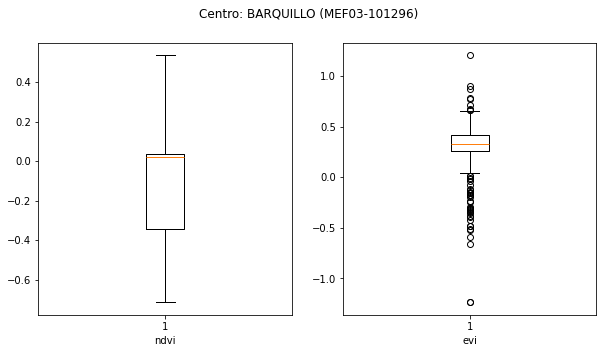

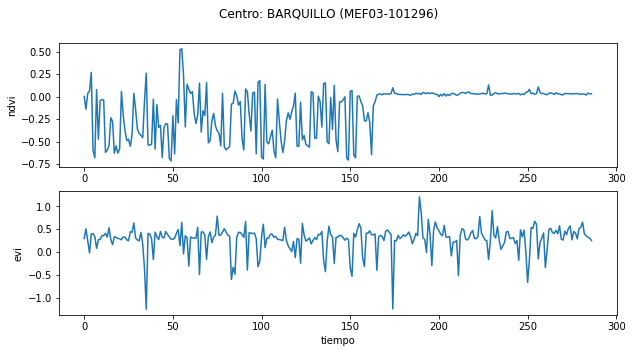

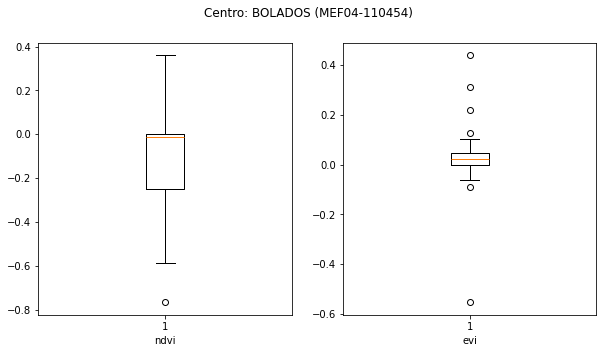

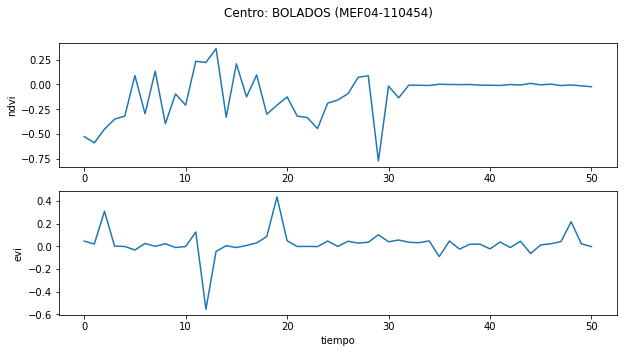

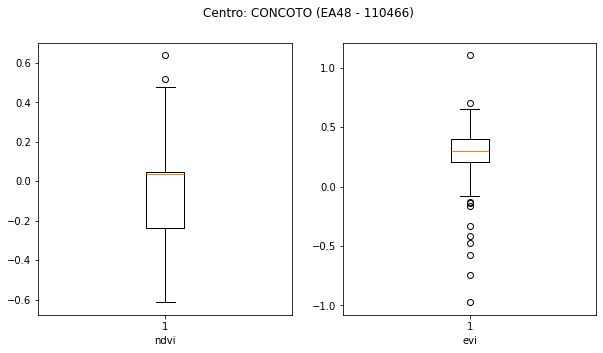

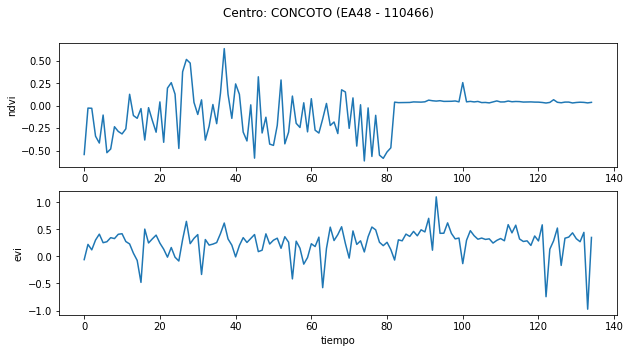

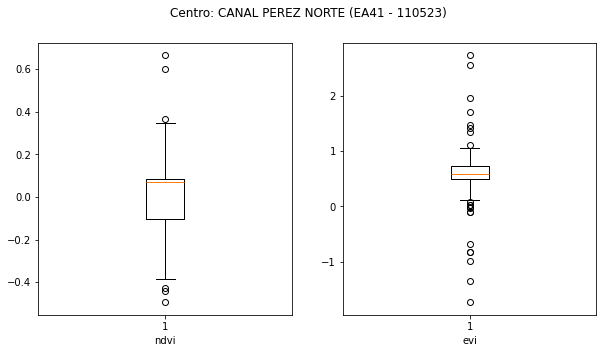

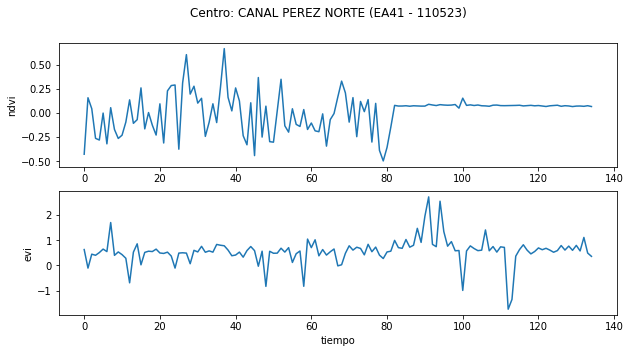

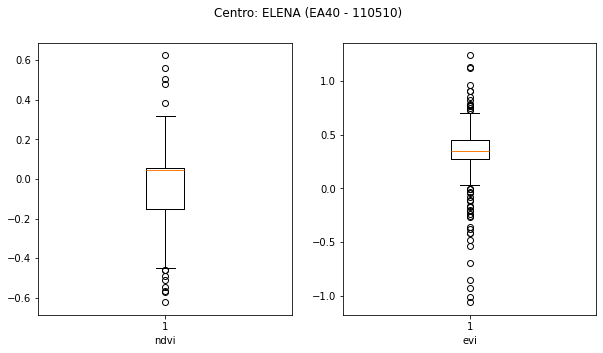

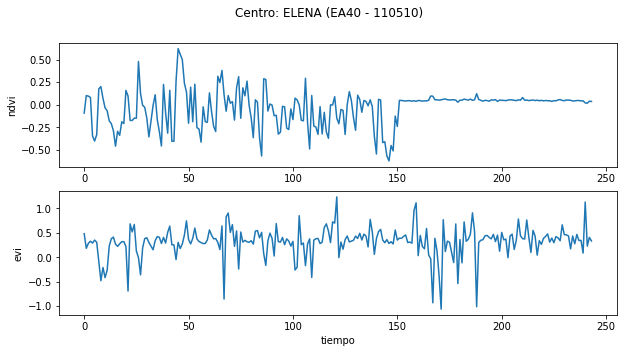

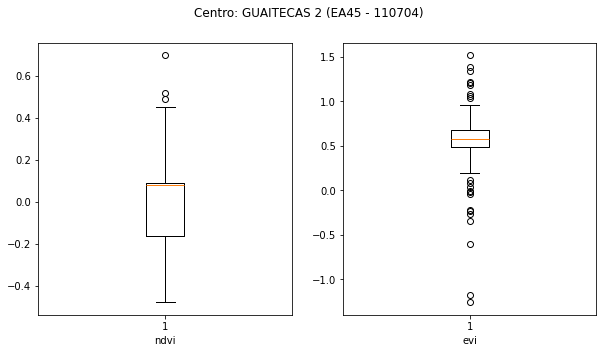

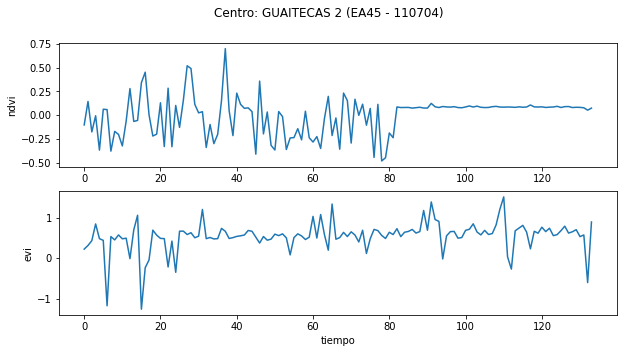

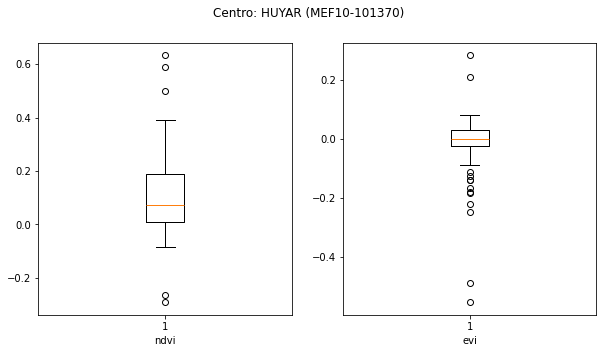

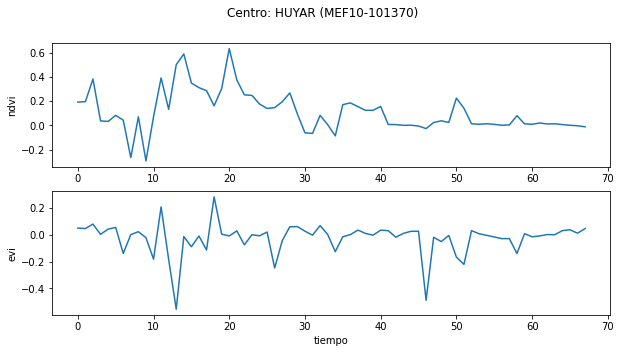

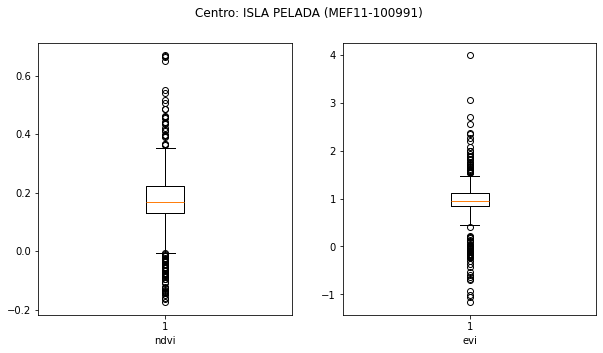

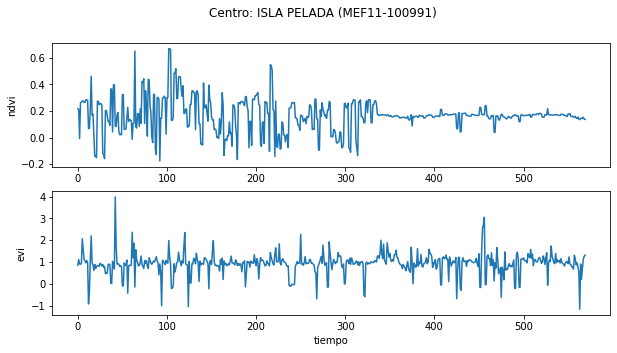

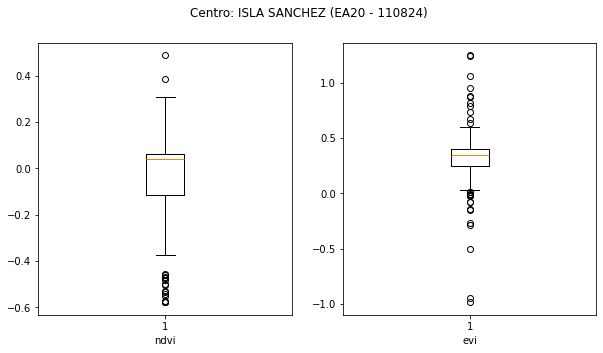

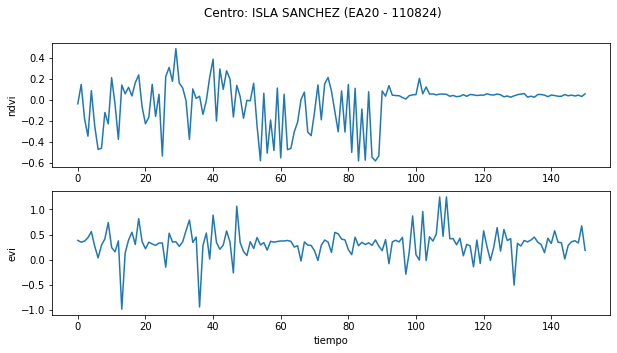

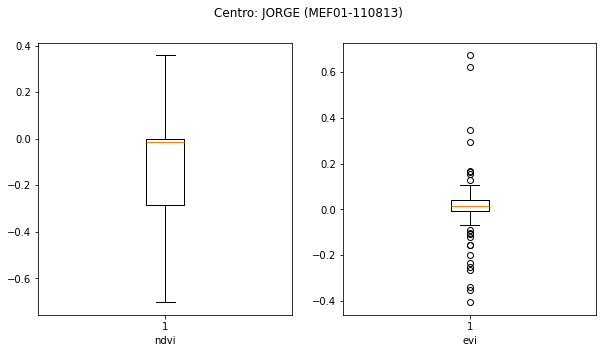

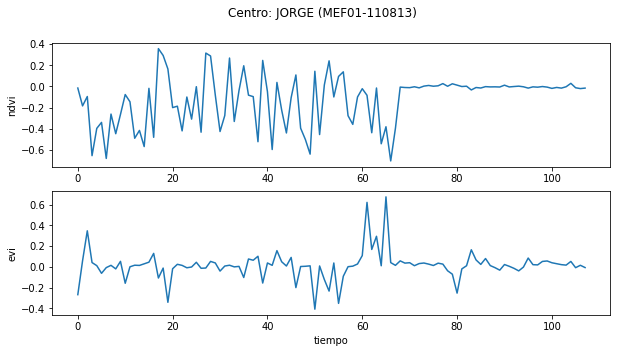

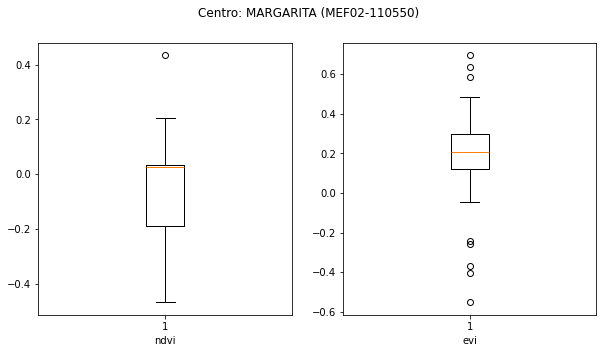

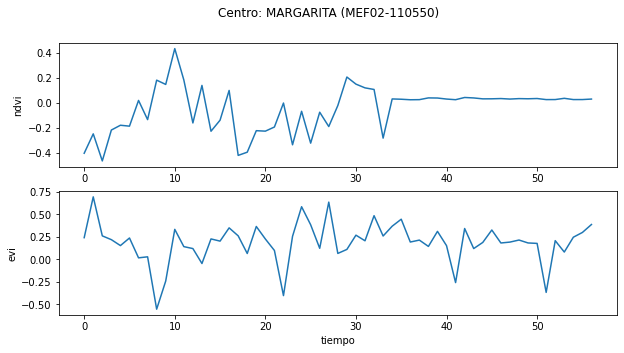

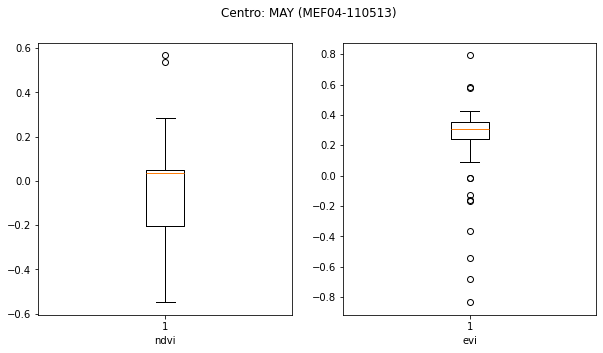

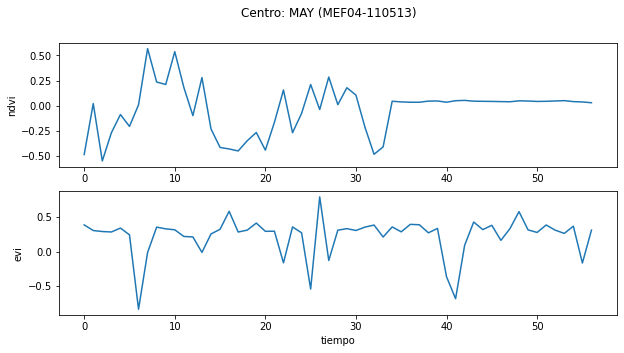

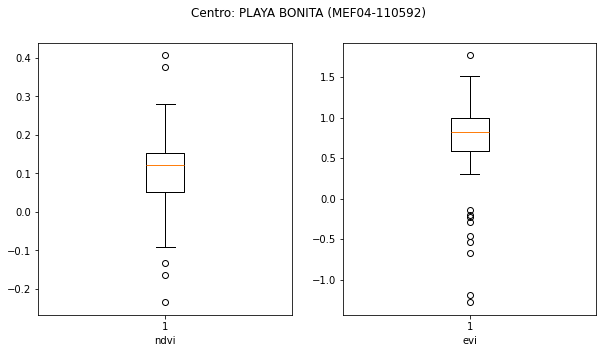

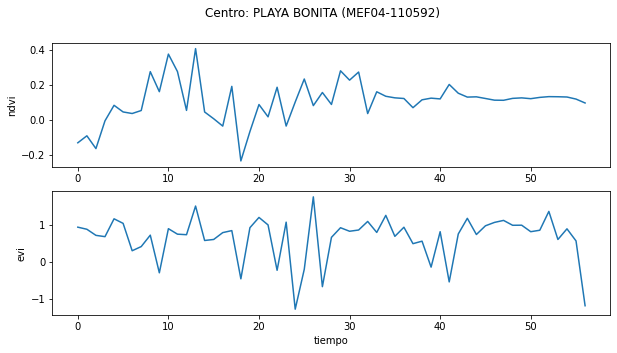

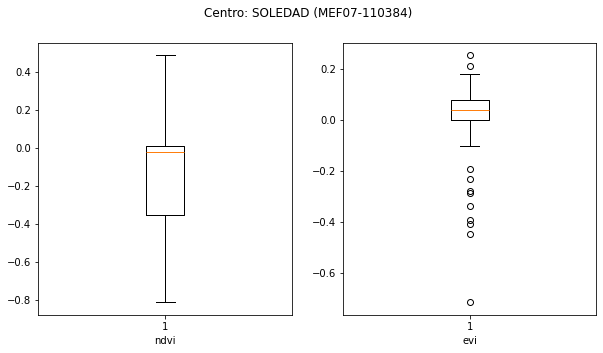

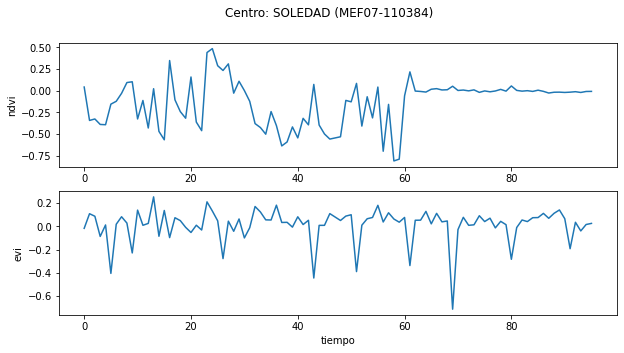

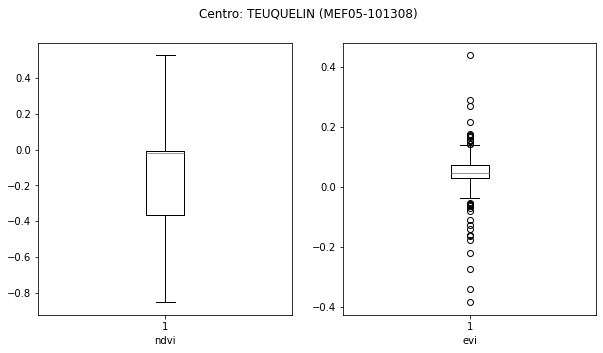

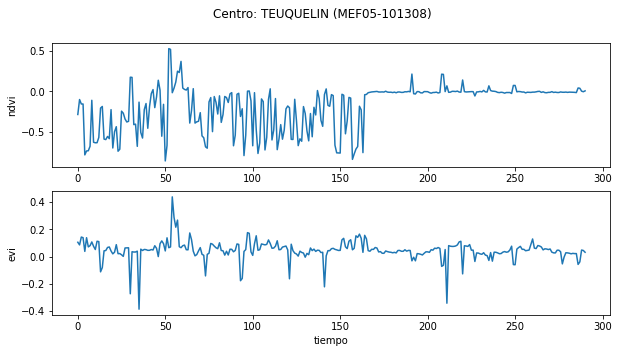

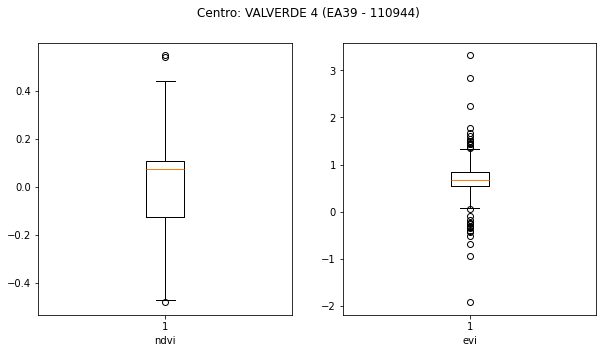

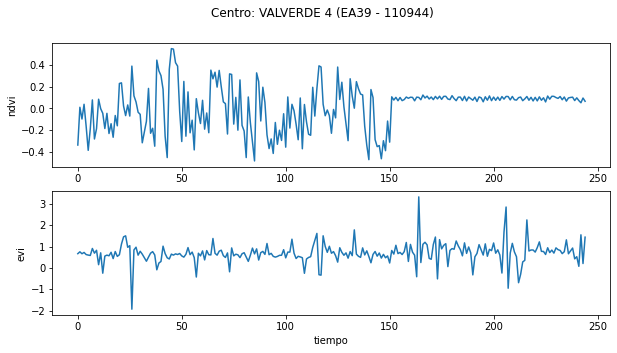

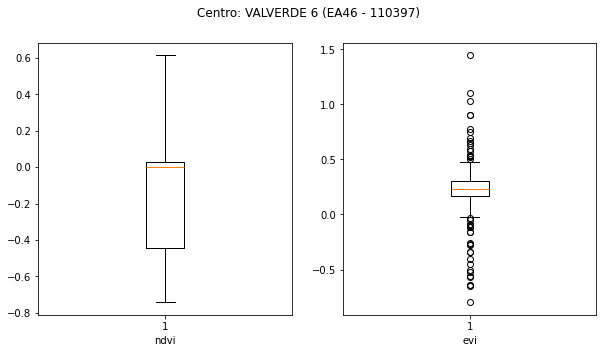

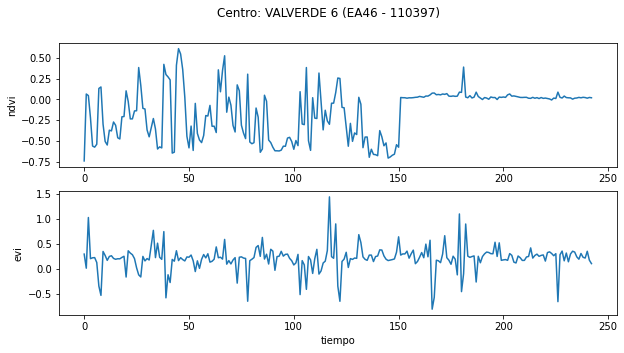

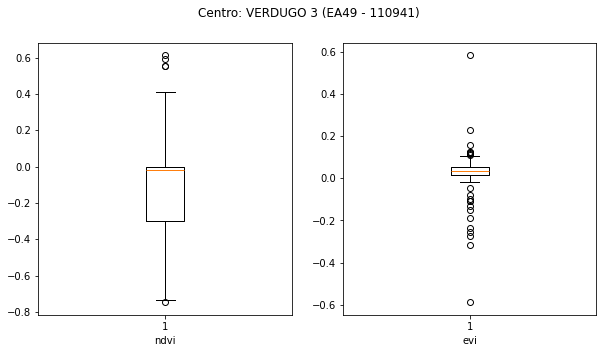

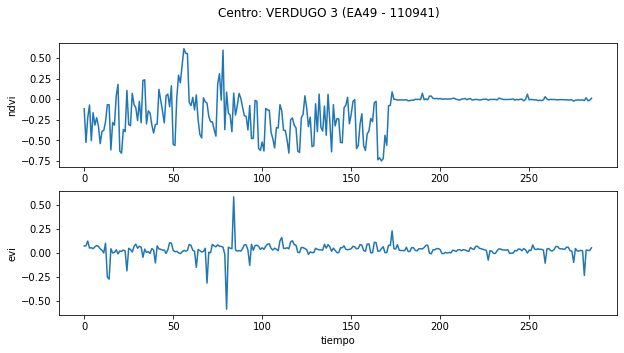

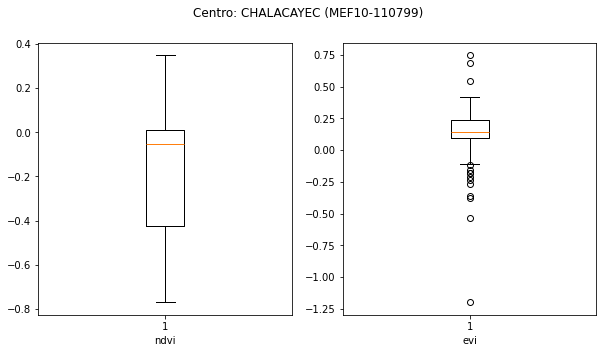

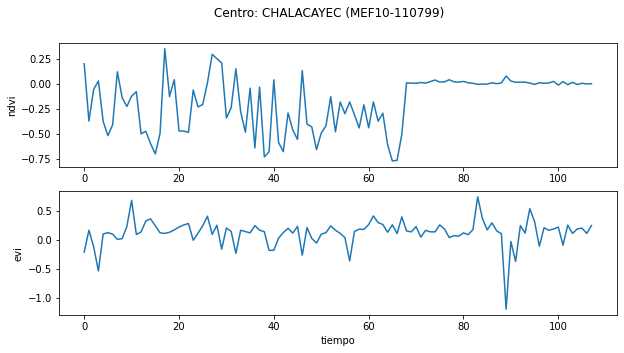

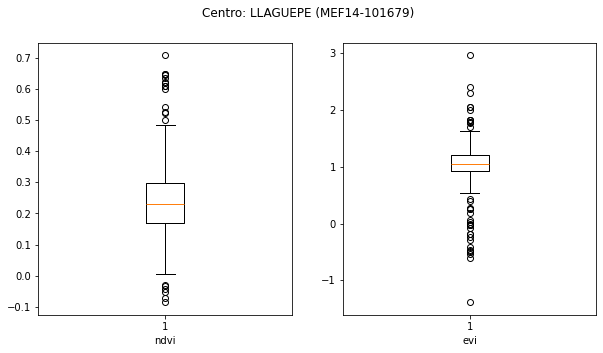

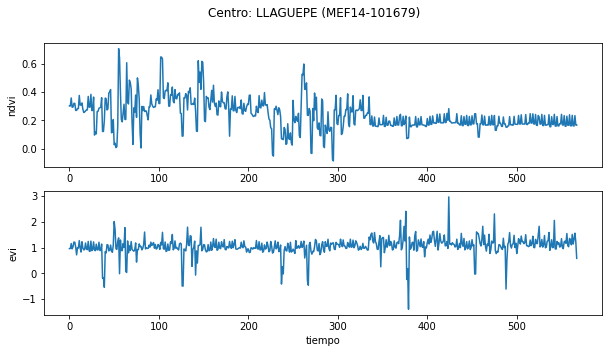

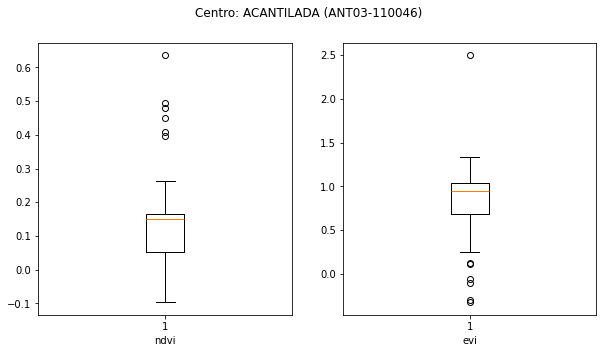

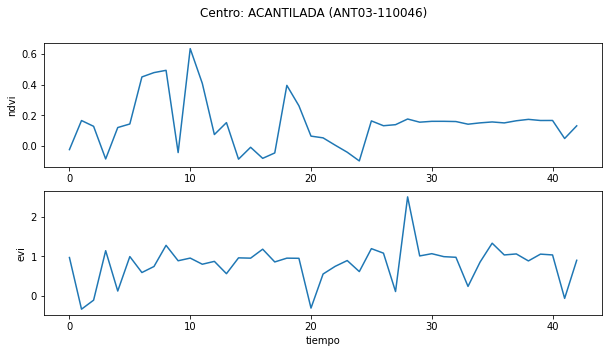

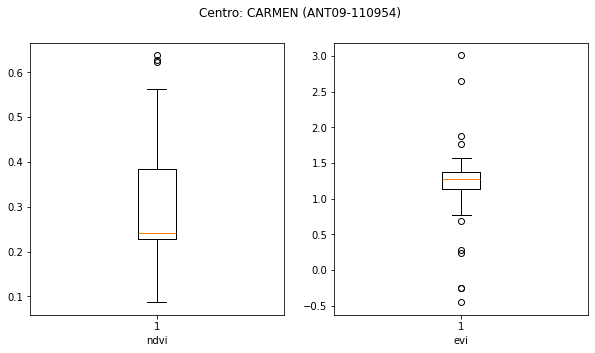

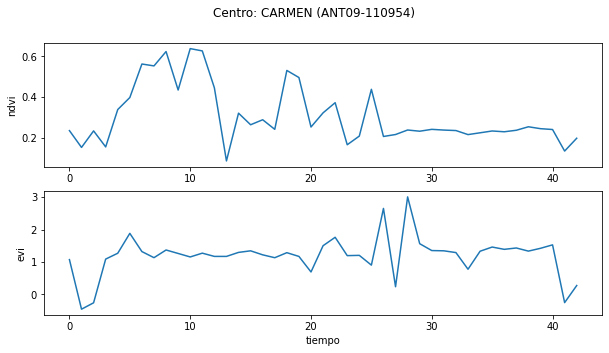

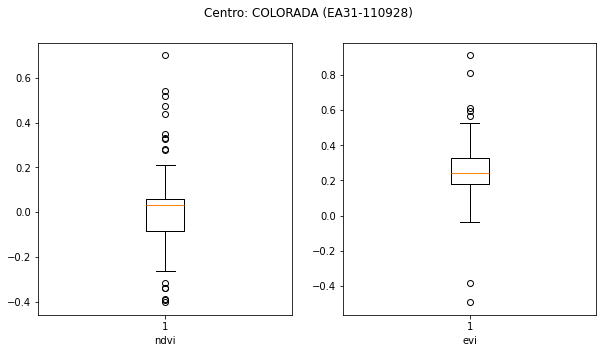

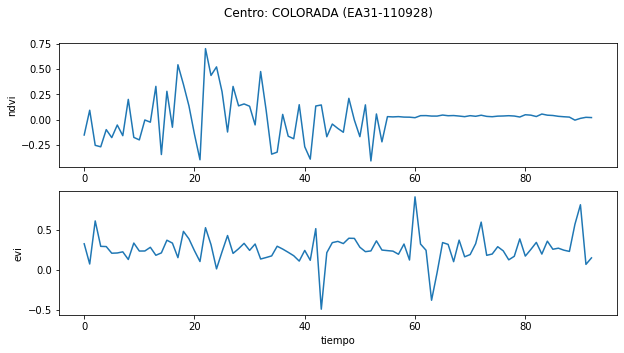

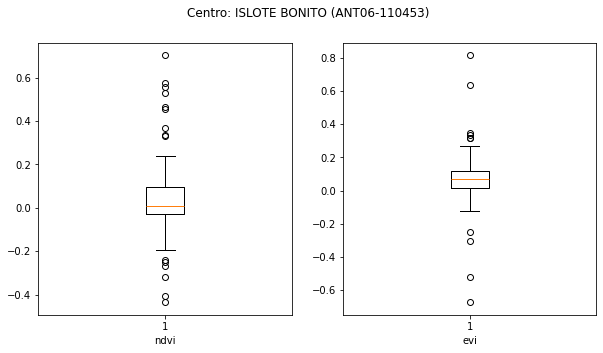

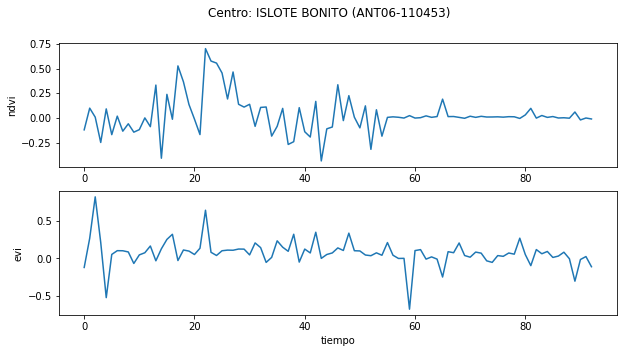

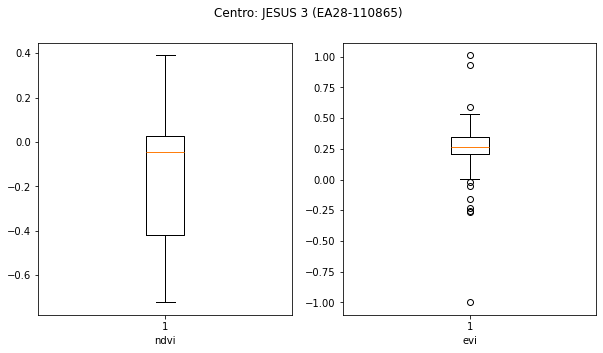

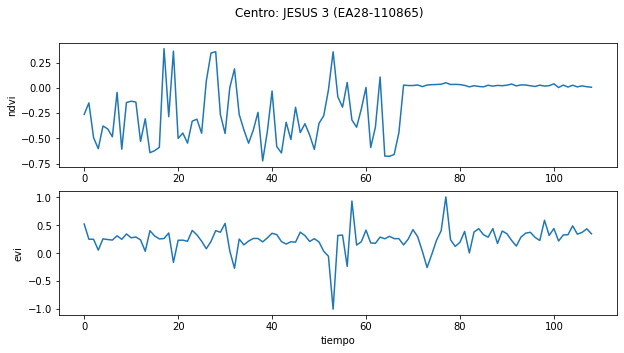

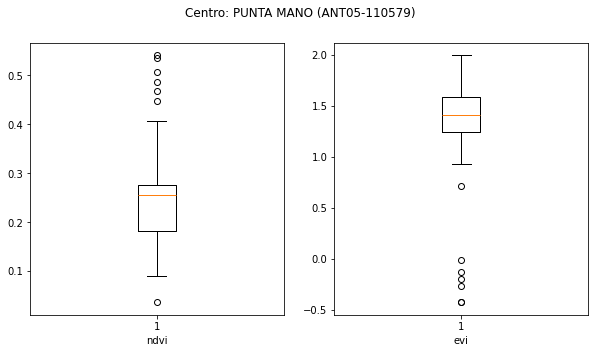

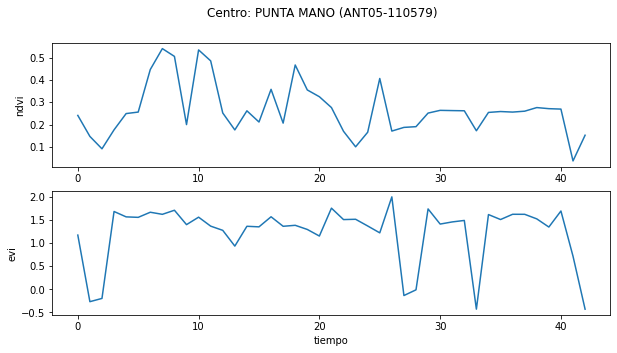

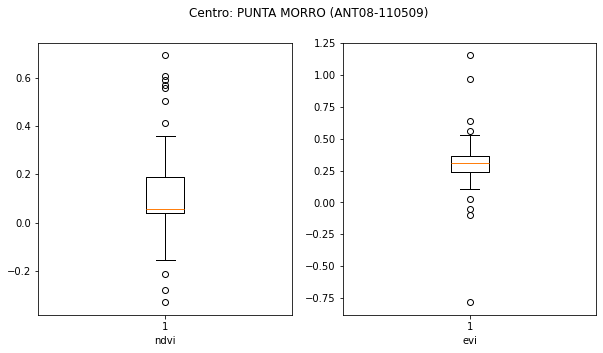

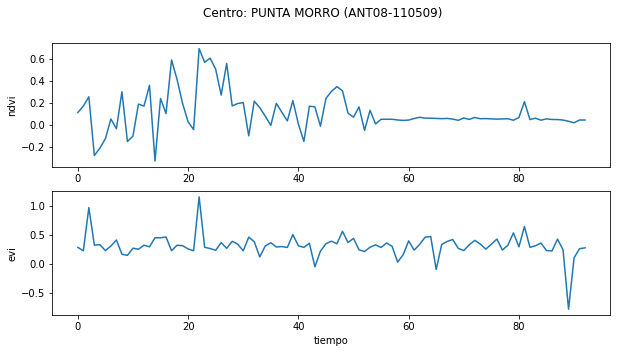

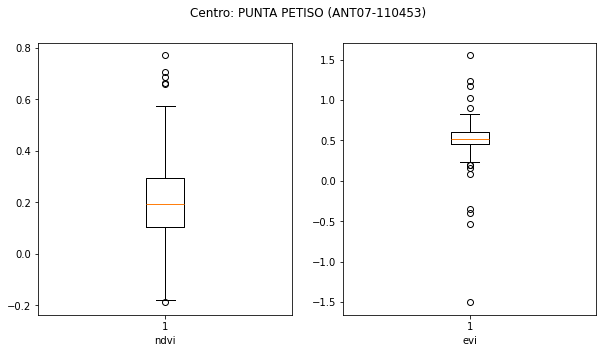

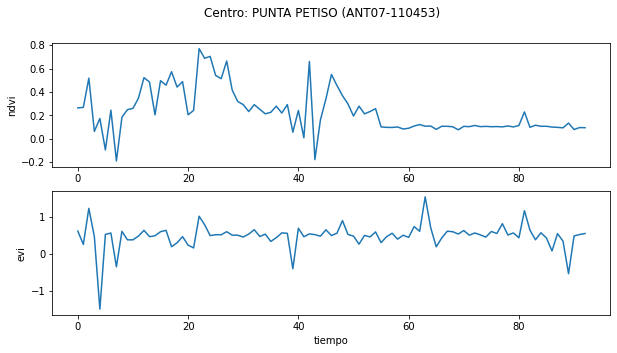

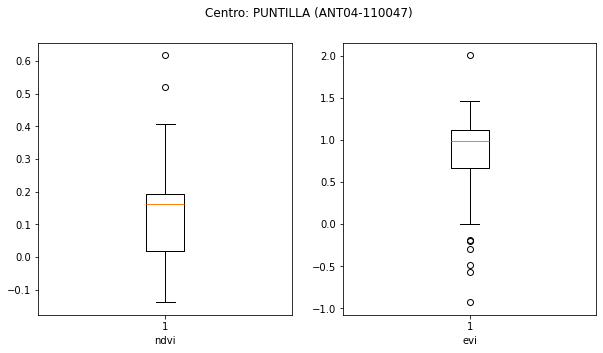

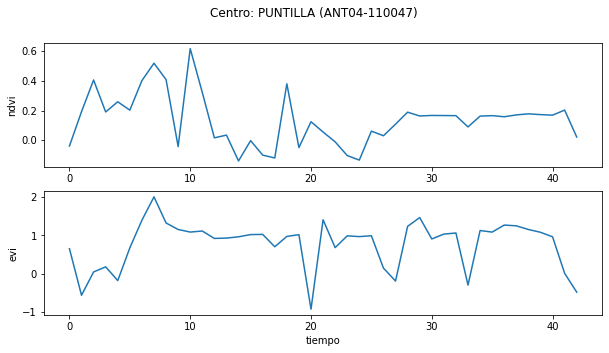

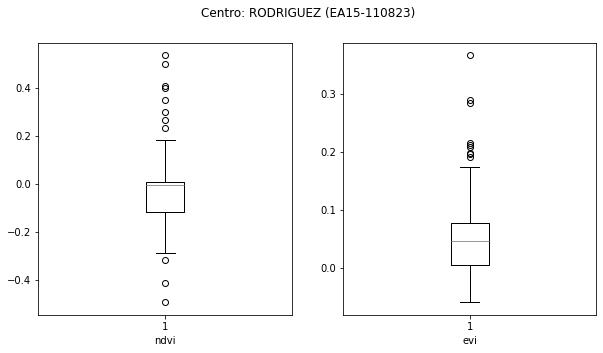

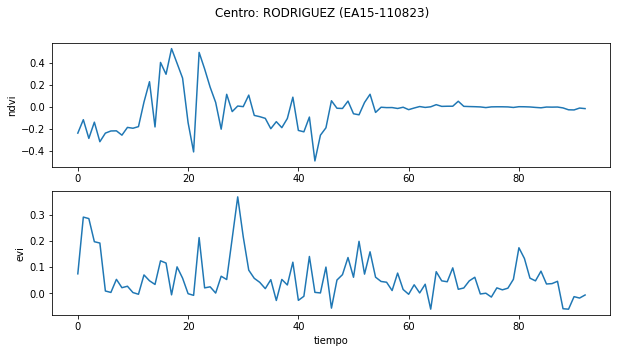

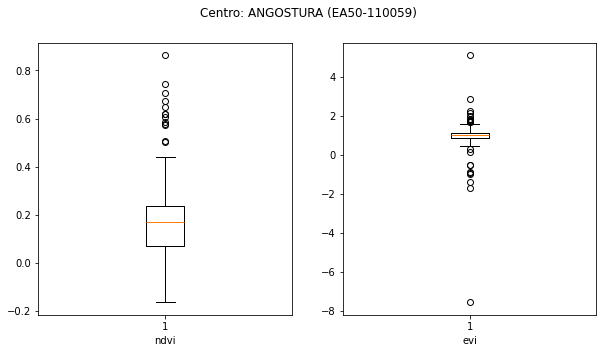

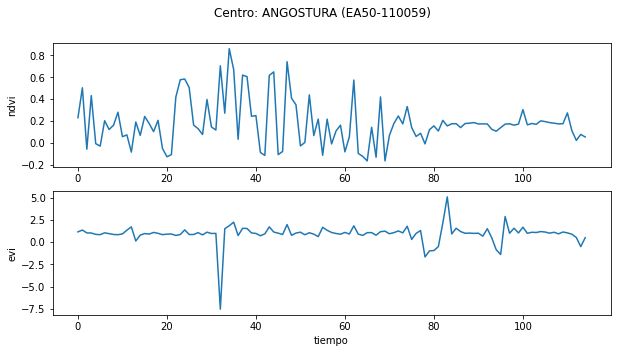

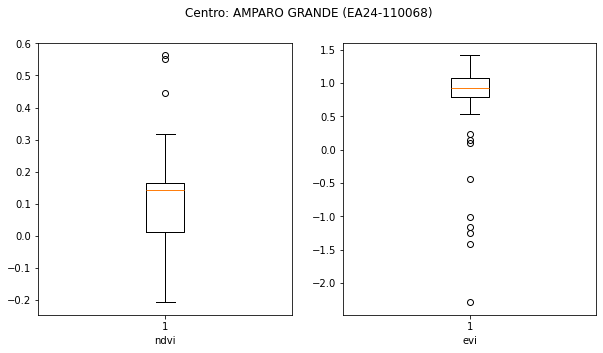

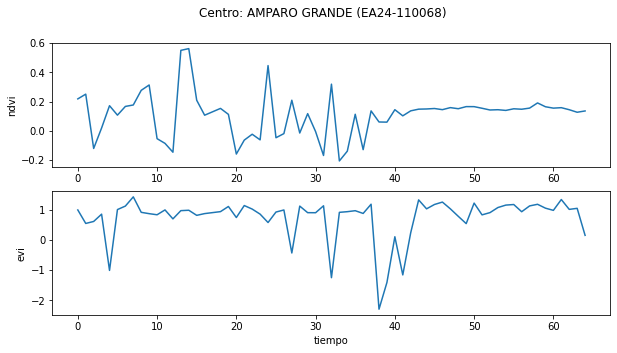

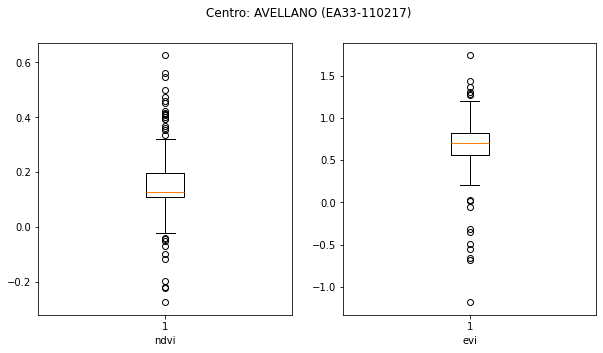

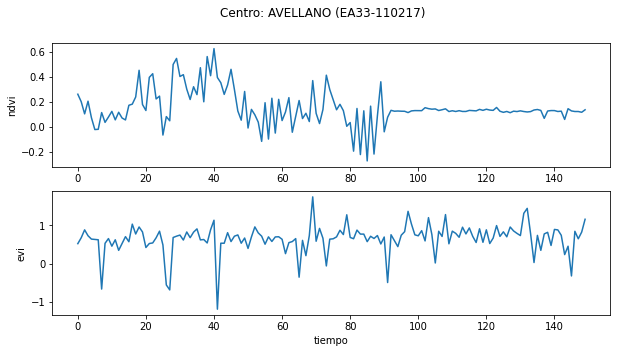

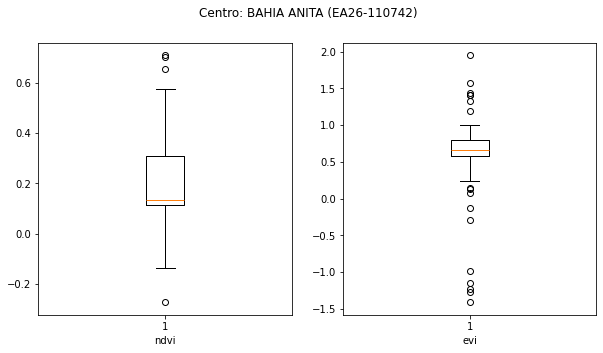

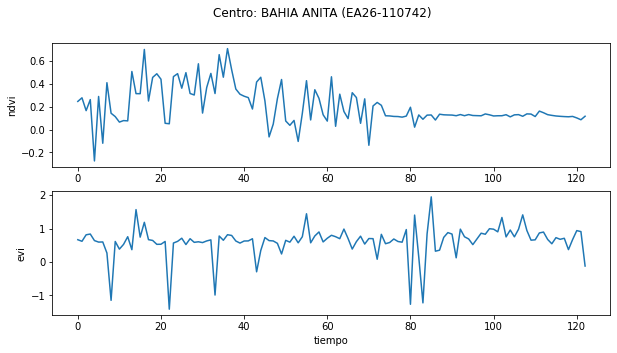

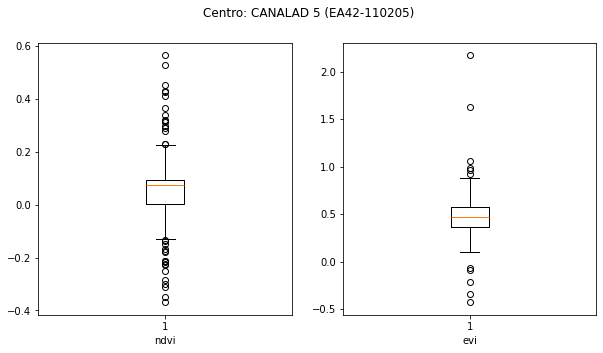

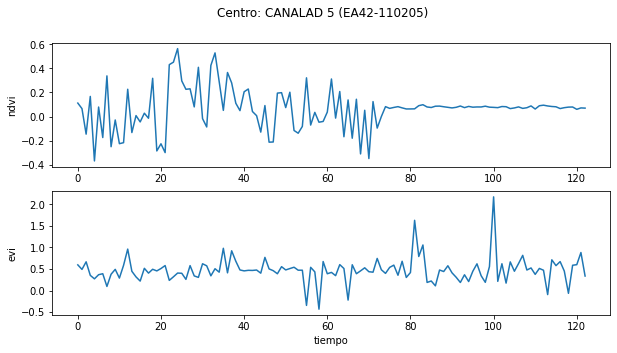

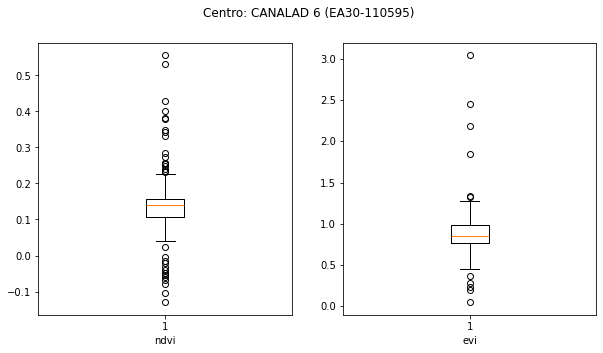

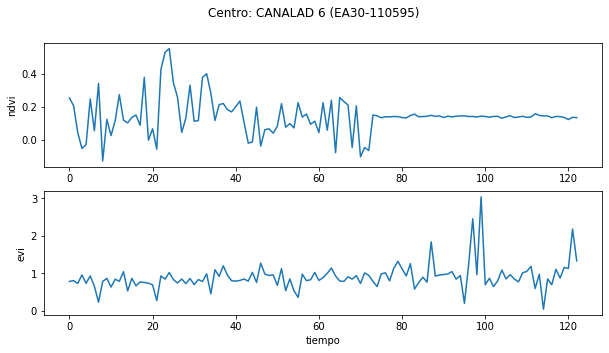

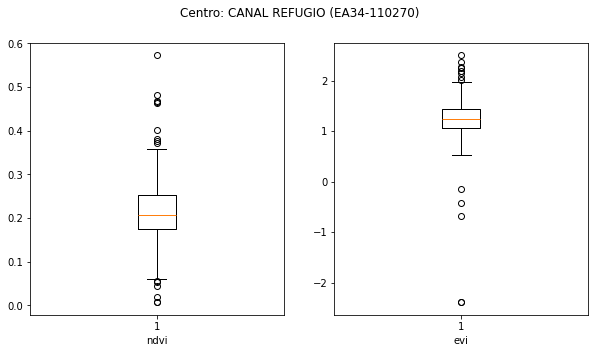

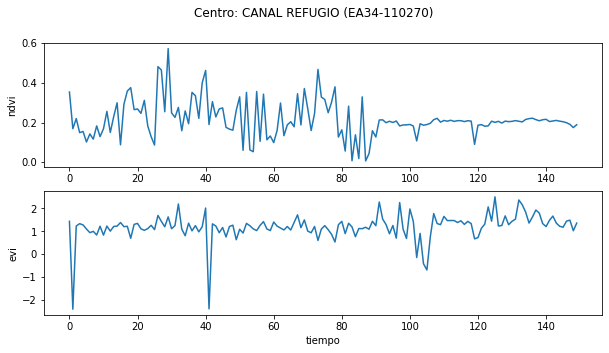

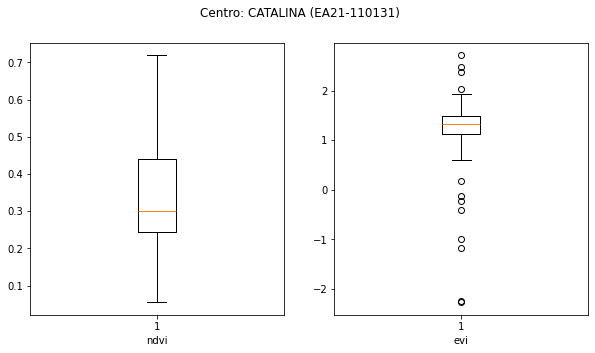

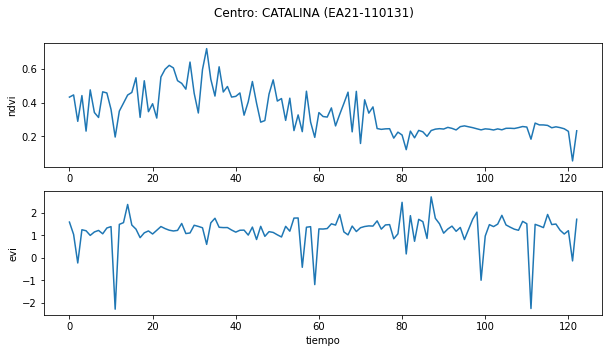

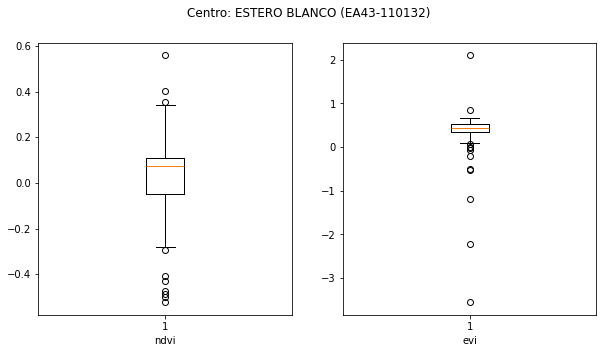

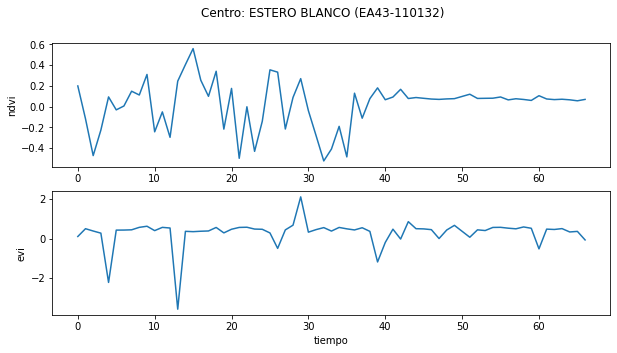

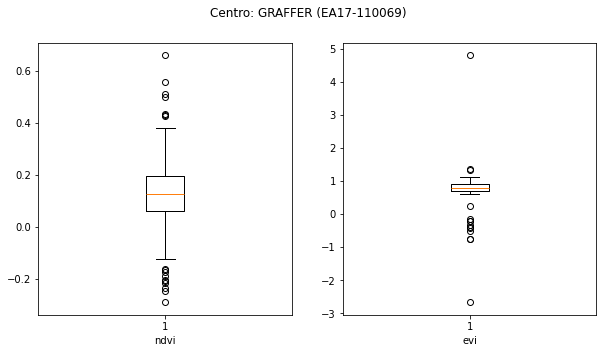

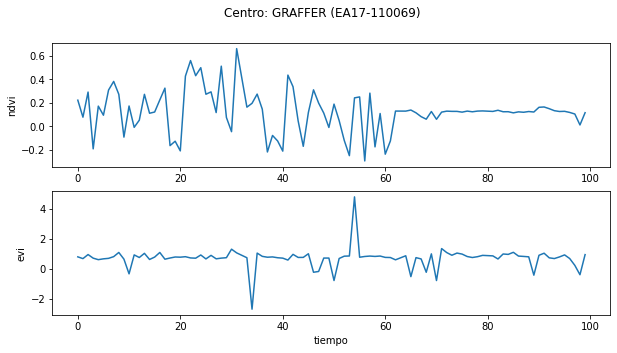

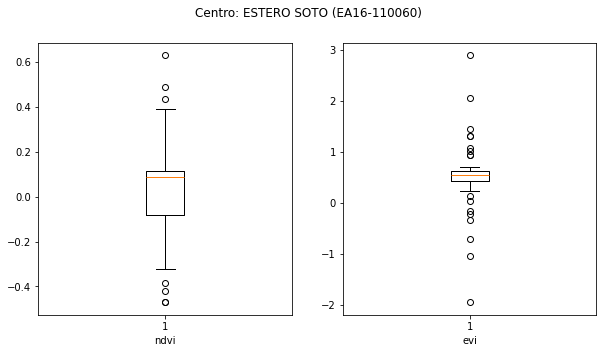

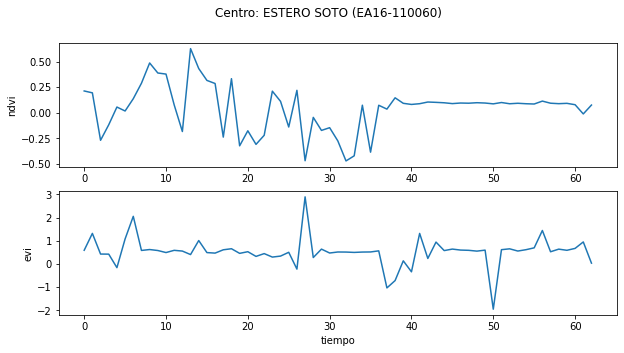

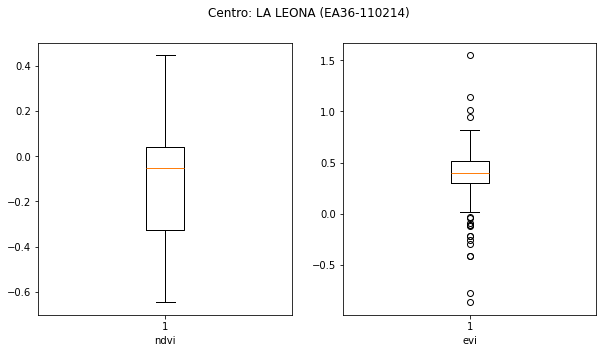

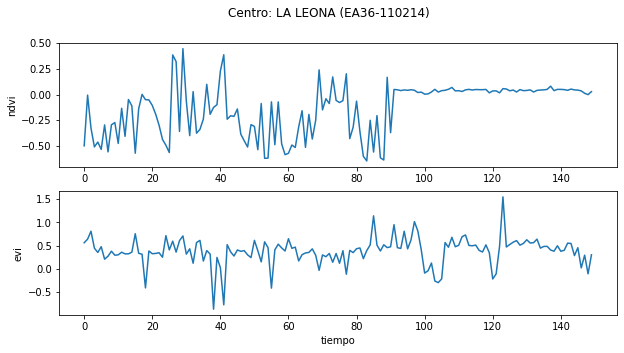

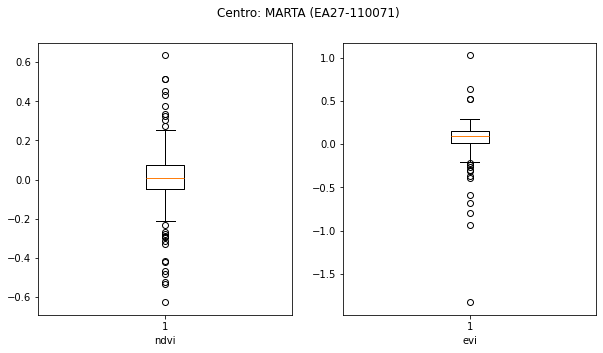

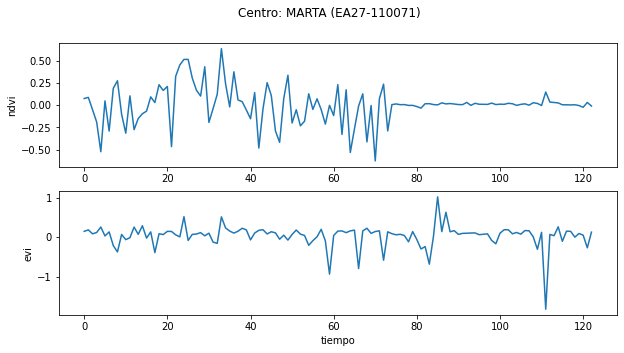

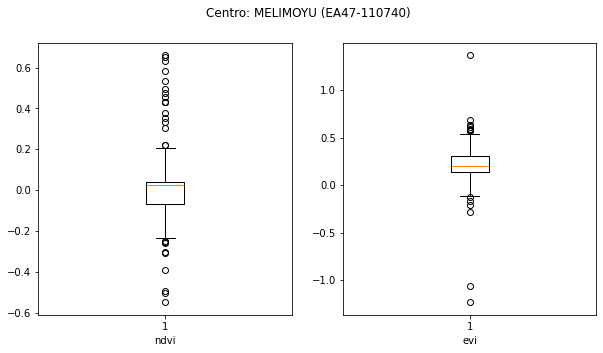

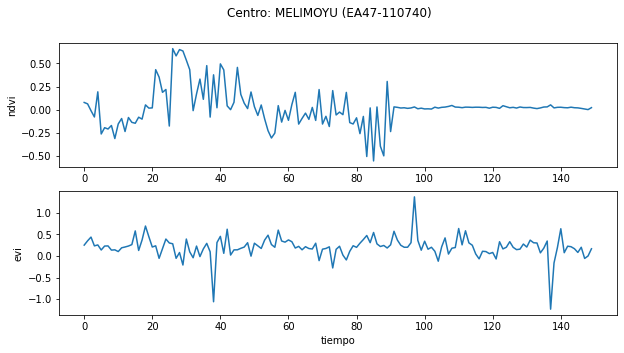

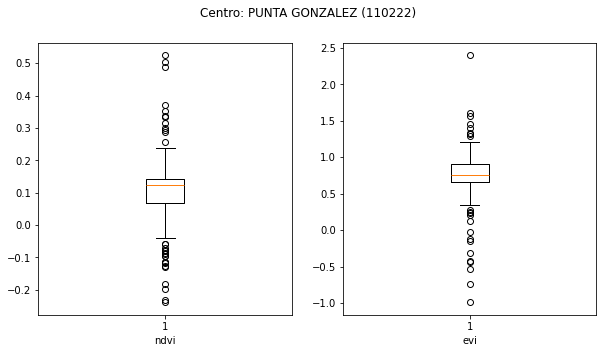

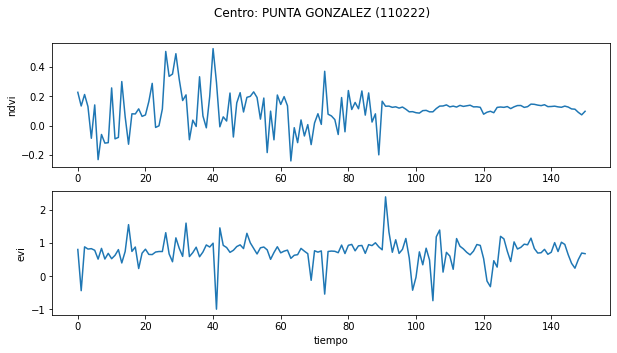

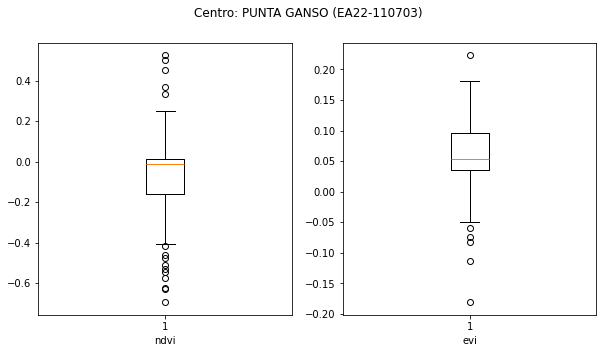

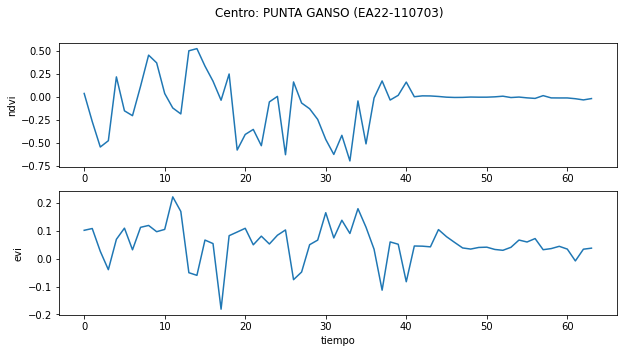

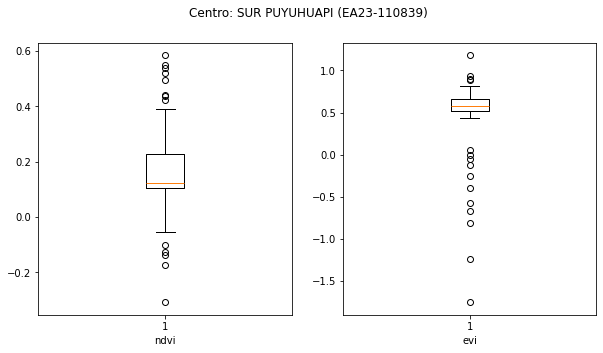

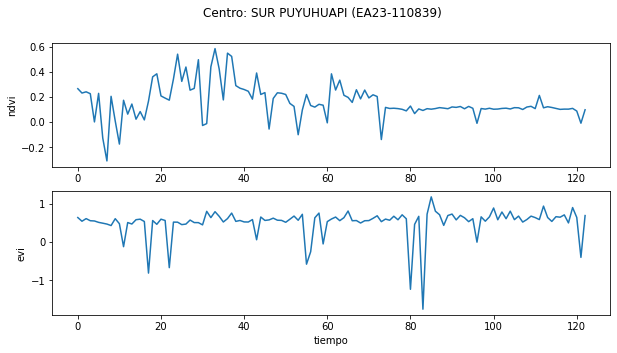

In [283]:
import seaborn as sns
import matplotlib.pyplot as plt


data = gpd.read_file('data_center.geojson').to_crs(4326)
for center in data['Name']:
    metrics = pd.read_csv(f'metrics/{center}.csv')
    metrics = metrics.dropna()
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    axs[0].boxplot(metrics['ndvi2'])
    axs[0].set_xlabel('ndvi')
    axs[1].boxplot(metrics['evi'])
    axs[1].set_xlabel('evi')
    plt.suptitle(f'Centro: {center}')
    plt.show()

    fig, axs = plt.subplots(2, 1, figsize=(10, 5))
    axs[0].plot(metrics['ndvi2'])
    axs[0].set_ylabel('ndvi')
    axs[1].plot(metrics['evi'])
    axs[1].set_ylabel('evi')
    plt.suptitle(f'Centro: {center}')
    plt.xlabel('tiempo')
    plt.show()

## Análisis más específico
## Caso 1: JORGE (MEF01-110813)

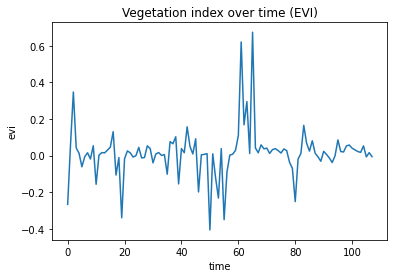

incidente entre: 2021-11-09 - 2022-01-18


In [356]:
centro = 'JORGE (MEF01-110813)'
data = gpd.read_file('data_center.geojson').to_crs(4326)
center = data[data['Name'] == centro]
center_location = list(center['geometry'].get_coordinates().values[0][::-1])

aoi = gpd.GeoSeries(center['geometry'].buffer(0.05, cap_style=3)).to_crs(4326).to_json()
aoi_bbox = ee.Geometry.Polygon(json.loads(aoi)['features'][0]['geometry']['coordinates'], 'EPSG:4326')

data_center = pd.read_csv(f'metrics/{centro}.csv')
data_center = data_center.dropna()
plt.plot(data_center['evi'])
plt.title('Vegetation index over time (EVI)')
plt.xlabel('time')
plt.ylabel('evi')
plt.show()
print(f'incidente entre: {list(data_center["time"])[60]} - {list(data_center["time"])[67]}')

Se puede ver que hubo un alza en la vegeación promedio entre los índices 60 y 67 aprox. Veremos a continuación si esto es producido por un bloom de algas

In [375]:
dates = ['2021-11-09', '2022-01-18']
clouds = 25
collection_copernicus, images_copernicus = get_copernicus_collection(aoi_bbox, dates, clouds=clouds)
image_copernicus = collection_copernicus.median()
image_copernicus = image_copernicus.clip(aoi_bbox) 


fecha = '2021-11-09'
dayOfInterest = ee.Date(fecha)
sentinel2_collection = ee.ImageCollection('COPERNICUS/S2_SR').filterDate(dayOfInterest, dayOfInterest.advance(10, 'day')).filterBounds(aoi_bbox)
calculate_evi_image = calculate_evi(sentinel2_collection).mean().clip(aoi_bbox)


Map = geemap.Map(center=center_location, zoom=13)
Map.addLayer(aoi_bbox)
visParams = {
    'min': -1,
    'max': 1,
    'palette': ['black', 'blue', 'purple', 'cyan', 'green', 'yellow', 'red']   
}
Map.addLayer(calculate_evi_image, visParams, 'EVI', True)
imageRGB = image_copernicus.visualize(**{'bands': ['TCI_R', 'TCI_G', 'TCI_B'],'min':0, 'max': 100})
Map.addLayer(imageRGB, {}, 'RGB', True)
Map

Se obtuvieron 5 imágenes del COPERNICUS


Map(center=[-45.2985822220971, -73.23471854601745], controls=(WidgetControl(options=['position', 'transparent_…

Efectivamente han aparecido algas!

## Caso 2: LA LEONA (EA36-110214)

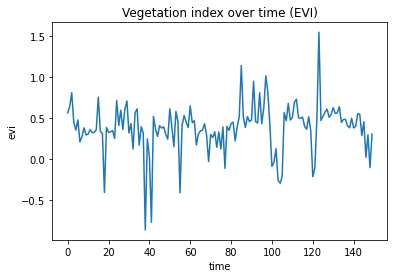

incidente entre: 2022-01-18 - 2022-05-25


In [357]:
centro = 'LA LEONA (EA36-110214)'
data = gpd.read_file('data_center.geojson').to_crs(4326)
center = data[data['Name'] == centro]
center_location = list(center['geometry'].get_coordinates().values[0][::-1])

aoi = gpd.GeoSeries(center['geometry'].buffer(0.05, cap_style=3)).to_crs(4326).to_json()
aoi_bbox = ee.Geometry.Polygon(json.loads(aoi)['features'][0]['geometry']['coordinates'], 'EPSG:4326')

data_center = pd.read_csv(f'metrics/{centro}.csv')
data_center = data_center.dropna()
plt.plot(data_center['evi'])
plt.title('Vegetation index over time (EVI)')
plt.xlabel('time')
plt.ylabel('evi')
plt.show()
print(f'incidente entre: {list(data_center["time"])[90]} - {list(data_center["time"])[100]}')

In [373]:
dates = ['2022-01-10', '2022-05-30']
clouds = 50
collection_copernicus, images_copernicus = get_copernicus_collection(aoi_bbox, dates, clouds=clouds)
image_copernicus = collection_copernicus.median()
image_copernicus = image_copernicus.clip(aoi_bbox) 


fecha = '2022-05-25'
dayOfInterest = ee.Date(fecha)
sentinel2_collection = ee.ImageCollection('COPERNICUS/S2_SR').filterDate(dayOfInterest, dayOfInterest.advance(10, 'day')).filterBounds(aoi_bbox)
calculate_evi_image = calculate_evi(sentinel2_collection).mean().clip(aoi_bbox)


Map = geemap.Map(center=center_location, zoom=13)
Map.addLayer(aoi_bbox)
visParams = {
    'min': -1,
    'max': 1,
    'palette': ['black', 'blue', 'purple', 'cyan', 'green', 'yellow', 'red']   
}
Map.addLayer(calculate_evi_image, visParams, 'EVI', True)

imageRGB = image_copernicus.visualize(**{'bands': ['TCI_R', 'TCI_G', 'TCI_B'],'min':0, 'max': 100})
Map.addLayer(imageRGB, {}, 'RGB', True)

Map

Se obtuvieron 13 imágenes del COPERNICUS


Map(center=[-45.2985822220971, -73.23471854601745], controls=(WidgetControl(options=['position', 'transparent_…

Se puede ver claramente como las algas se concentran alrededor de los centros salamoneros!!!

## Caso 3: ISLOTE BONITO (ANT06-110453)

En los casos anteriores hemos usado el indicador EVI para análizar el bloom de algas. Sin embargo el NDVI también es últil, ahora veremos un caso de ejemplo

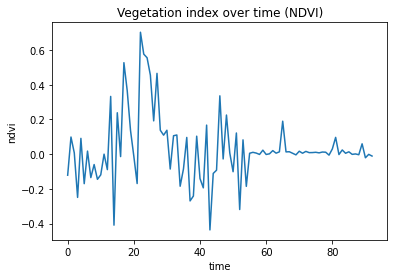

incidente entre: 2020-04-08 - 2020-12-04


In [358]:
centro = 'ISLOTE BONITO (ANT06-110453)'
data = gpd.read_file('data_center.geojson').to_crs(4326)
center = data[data['Name'] == centro]
center_location = list(center['geometry'].get_coordinates().values[0][::-1])

aoi = gpd.GeoSeries(center['geometry'].buffer(0.05, cap_style=3)).to_crs(4326).to_json()
aoi_bbox = ee.Geometry.Polygon(json.loads(aoi)['features'][0]['geometry']['coordinates'], 'EPSG:4326')

data_center = pd.read_csv(f'metrics/{centro}.csv')
data_center = data_center.dropna()
plt.plot(data_center['ndvi2'])
plt.title('Vegetation index over time (NDVI)')
plt.xlabel('time')
plt.ylabel('ndvi')
plt.show()
print(f'incidente entre: {list(data_center["time"])[20]} - {list(data_center["time"])[30]}')

In [376]:
dates = ['2020-04-01', '2020-12-10']
clouds = 50
collection_copernicus, images_copernicus = get_copernicus_collection(aoi_bbox, dates, clouds=clouds)
image_copernicus = collection_copernicus.median()
image_copernicus = image_copernicus.clip(aoi_bbox) 

fecha = '2020-04-01'
dayOfInterest = ee.Date(fecha)
sentinel2_collection = ee.ImageCollection('COPERNICUS/S2_SR').filterDate(dayOfInterest, dayOfInterest.advance(10, 'day')).filterBounds(aoi_bbox)
calculate_evi_image = calculate_evi(sentinel2_collection).mean().clip(aoi_bbox)

Map = geemap.Map(center=center_location, zoom=13)
Map.addLayer(aoi_bbox)
visParams = {
    'min': -1,
    'max': 1,
    'palette': ['black', 'blue', 'purple', 'cyan', 'green', 'yellow', 'red']   
}
Map.addLayer(calculate_evi_image, visParams, 'EVI')
imageRGB = image_copernicus.visualize(**{'bands': ['TCI_R', 'TCI_G', 'TCI_B'],'min':0, 'max': 100})
Map.addLayer(imageRGB, {}, 'RGB', True)
Map

Se obtuvieron 33 imágenes del COPERNICUS


Map(center=[-45.2985822220971, -73.23471854601745], controls=(WidgetControl(options=['position', 'transparent_…

In [230]:
centro = 'ISLOTE BONITO (ANT06-110453)'
data = gpd.read_file('data_center.geojson').to_crs(4326)
center = data[data['Name'] == centro]
center_location = list(center['geometry'].get_coordinates().values[0][::-1])

aoi = gpd.GeoSeries(center['geometry'].buffer(0.005)).to_crs(4326).to_json()
aoi_bbox = ee.Geometry.Polygon(json.loads(aoi)['features'][0]['geometry']['coordinates'], 'EPSG:4326')

bloom_enero, images = get_copernicus_collection(aoi_bbox, ['2022-04-01', '2022-07-01'], 20)
chla_bloom_enero = calculate_evi(bloom_enero)
videoArgs = {'dimensions': 512,
             'region': aoi_bbox,
             'framesPerSecond': 6,
             'crs': 'EPSG:4326',
             'min': -1,
             'max': 1,
             'palette': ['black', 'blue', 'purple', 'cyan', 'green', 'yellow', 'red']}

print(chla_bloom_enero.getVideoThumbURL(videoArgs))

Se obtuvieron 4 imágenes del COPERNICUS
https://earthengine.googleapis.com/v1/projects/cibravo2/videoThumbnails/2e2e9652c30ea23fdade94de6259dd30-e915d64c38a2127369fda61affa58e01:getPixels


In [232]:
centro = 'ISLOTE BONITO (ANT06-110453)'
data = gpd.read_file('data_center.geojson').to_crs(4326)
center = data[data['Name'] == centro]
center_location = list(center['geometry'].get_coordinates().values[0][::-1])

aoi = gpd.GeoSeries(center['geometry'].buffer(0.005)).to_crs(4326).to_json()
aoi_bbox = ee.Geometry.Polygon(json.loads(aoi)['features'][0]['geometry']['coordinates'], 'EPSG:4326')

bloom_enero, images = get_copernicus_collection(aoi_bbox, ['2020-03-01', '2022-04-01'], 20)
chla_bloom_enero = calculate_evi(bloom_enero)
videoArgs = {'dimensions': 512,
             'region': aoi_bbox,
             'framesPerSecond': 6,
             'crs': 'EPSG:4326',
             'min': -1,
             'max': 1,
             'palette': ['black', 'blue', 'purple', 'cyan', 'green', 'yellow', 'red']}

print(chla_bloom_enero.getVideoThumbURL(videoArgs))

Se obtuvieron 41 imágenes del COPERNICUS
https://earthengine.googleapis.com/v1/projects/cibravo2/videoThumbnails/34c83cc64079a57641297b12aaf02d07-8f71f9f6aab44f30f06045b19d5d4c4d:getPixels
